<a href="https://colab.research.google.com/github/DommiiUdomp/ANN/blob/main/ANNintro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANN Overview**

**Introduction**

Artificial Neural Networks (ANN) are multi-layer fully-connected neural nets that look like the figure below. They consist of an input layer, multiple hidden layers, and an output layer. Every node in one layer is connected to every other node in the next layer. We make the network deeper by increasing the number of hidden layers.

Import the libralies

In [213]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Utility Functions

In [215]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    predict_y = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0) 
    Z = np.argmax(predict_y,axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred_class = (model.predict(X) > 0.5).astype("int32")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred_class)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# **Logistic Regression**

Despite its name, logistic regression (LR) is a binary classification algorithm. It's the most popular technique for 0/1 classification. LR will try to draw a straight line to separate the classes, that's where the term linear model comes from. LR works on arbitrary dimensions, not just two. For 3 dimensional data it'll try to draw a 2 dimensional plane to separate the classes. This generalizes to N dimensional data and N-1 dimensional hyperplane separator. If you have a supervised binary classification problem, given an input data with multiple columns and a binary 0/1 outcome, LR is the first method to try. In this section we will focus on 2 dimensional data since it's easier to visualize, and in the later sections we will work with multidimensional input.

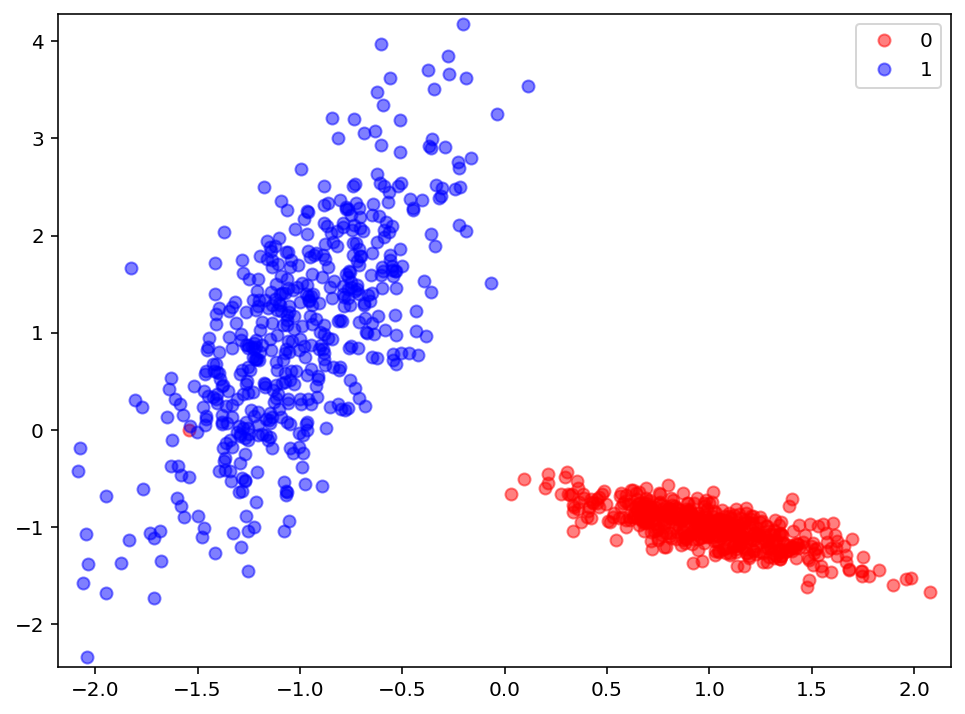

In [ ]:
#Linearly Separable Data

X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


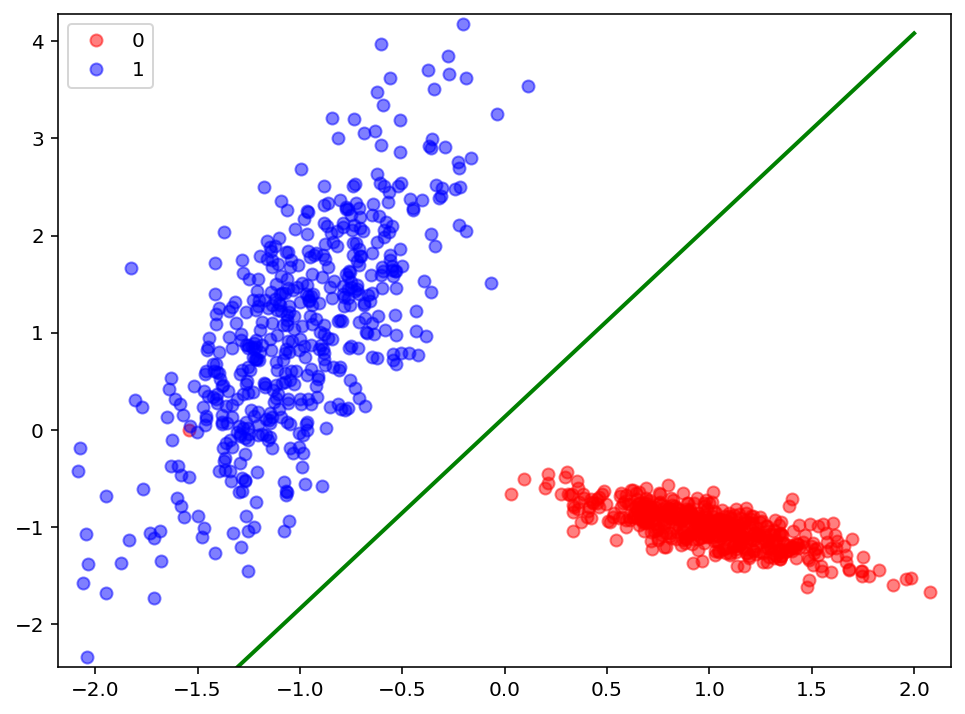

In [ ]:
# LogisticRegression classifier available in scikit-learn
lr = LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

Keras documentation at https://keras.io/ 

The Sequential model allows us to build deep neural networks, by stacking layers one top of another. Since we're now building a simple logistic regression model, we will have the input nodes directly connected to output node, without any hidden layers.

In neural networks literature, it's common to talk about input nodes and output nodes. 2 features, the x and y coordinates of the points we plotted above, so we have 2 input nodes as a vector of 2 numbers. The output of the logistic regression model is a single number between 0 and 1.

The Dense function constructs a fully connected neural network layer, automatically initializing the weights as biases. 

Input_shape: The first layer in models need to specify the input dimensions. The subsequent layers, the x and y coordinates. The input_shape parameter expects a vector, so in our case it's simply a tuple with one number.

Activation: The activation function of a logistic regression model is the logistic function

Then compile the model. This creates the neural network model by configuring the learning process. Specifying the optimizer to use and the loss function to minimize and metrics for classification problems as accuracy.

verbose // epochs

#Model 1

<Figure size 576x432 with 0 Axes>

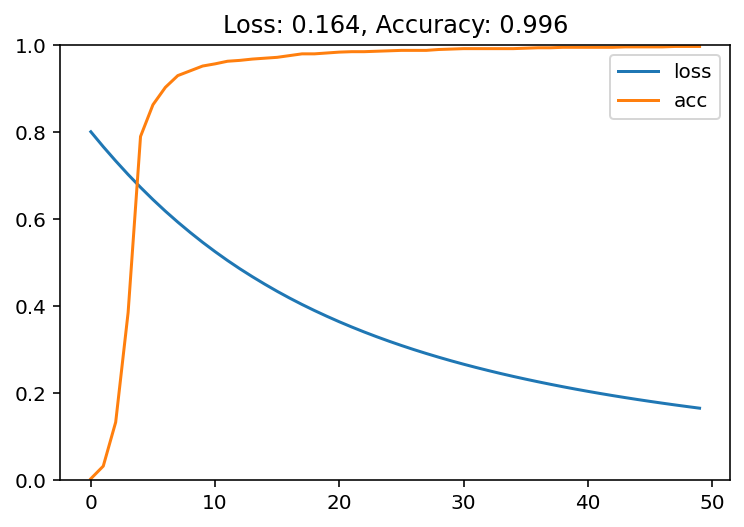

In [ ]:
model_1 = Sequential()
model_1.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_1 = model_1.fit(x=X, y=y, verbose=0, epochs=50)
plot_loss_accuracy(history_1)

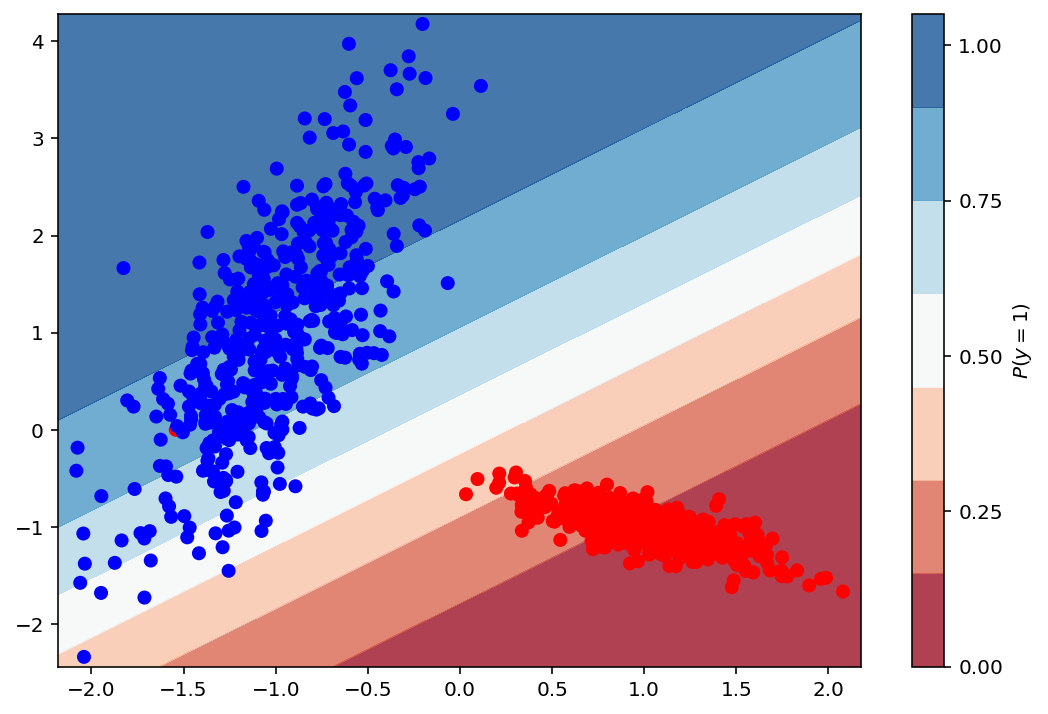

In [ ]:
#A fancy plot of the decision boundary
plot_decision_boundary(lambda x: model_1.predict(x), X, y)

In [ ]:
#y_pred = model.predict(X, verbose = 0)
#y_class = np.round(y_pred).astype(int)
y_pred_1 = (model_1.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       501
           1       1.00      0.99      1.00       499

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



The confusion matrix shows us how many classes were correctly classified vs misclassified. The numbers on the diagonal axis represent the number of correctly classified points, the rest are the misclassified ones. This particular matrix is not very interesting because the model correctly predicts the class of all but one point. We can see the misclassified point at the top right part of the confusion matrix, true value is class 0 but the predicted value is class 1.

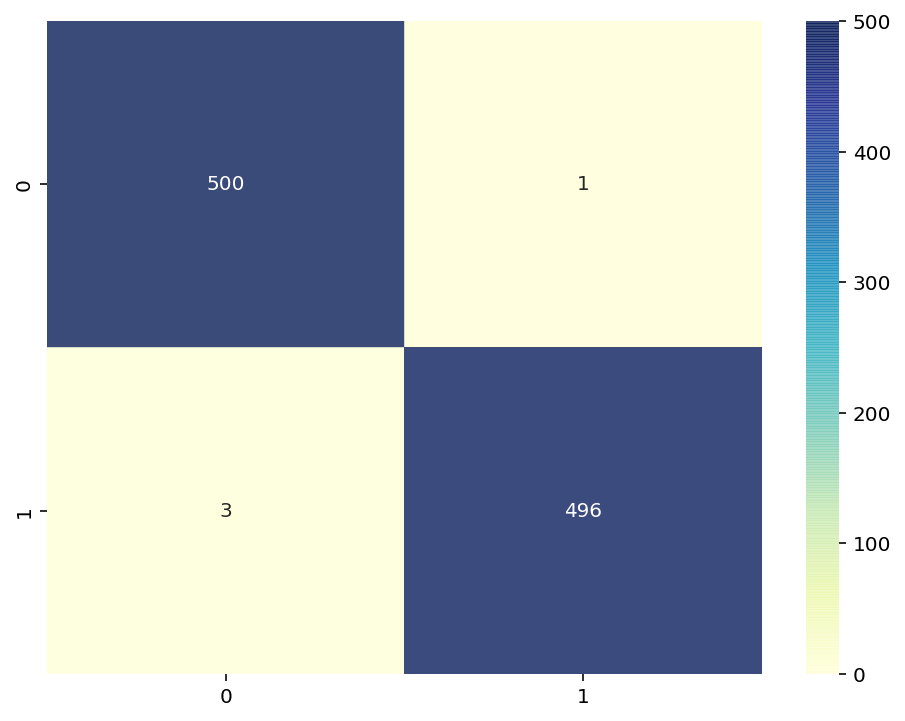

In [ ]:
plot_confusion_matrix(model_1, X, y)

#Model 2

Complex Data - Moons

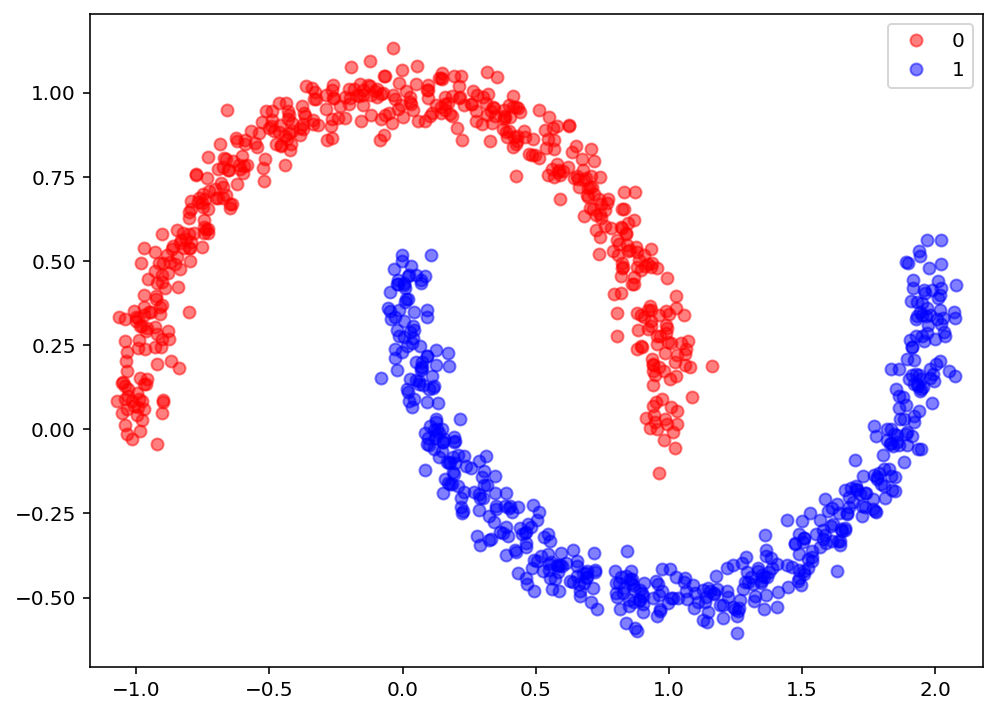

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

building the another logistic regression model with the same parameters as we did before.

<Figure size 576x432 with 0 Axes>

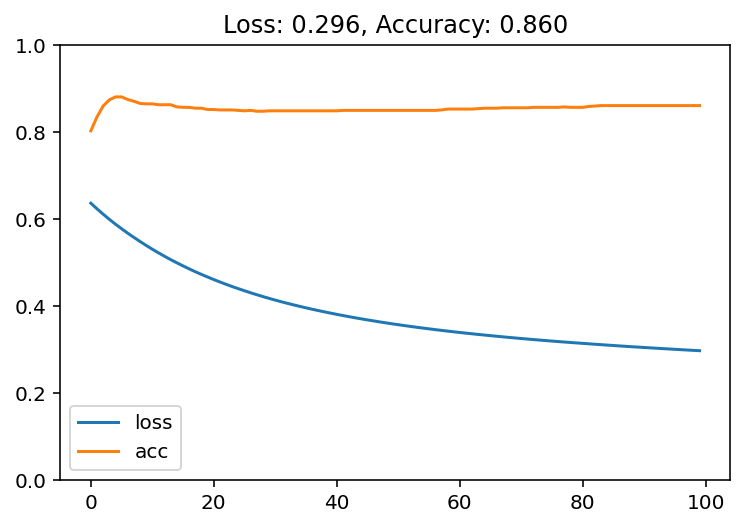

In [ ]:
model_2 = Sequential()
model_2.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model_2.compile('adam', 'binary_crossentropy', metrics=['acc'])

history_2 = model_2.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history_2)

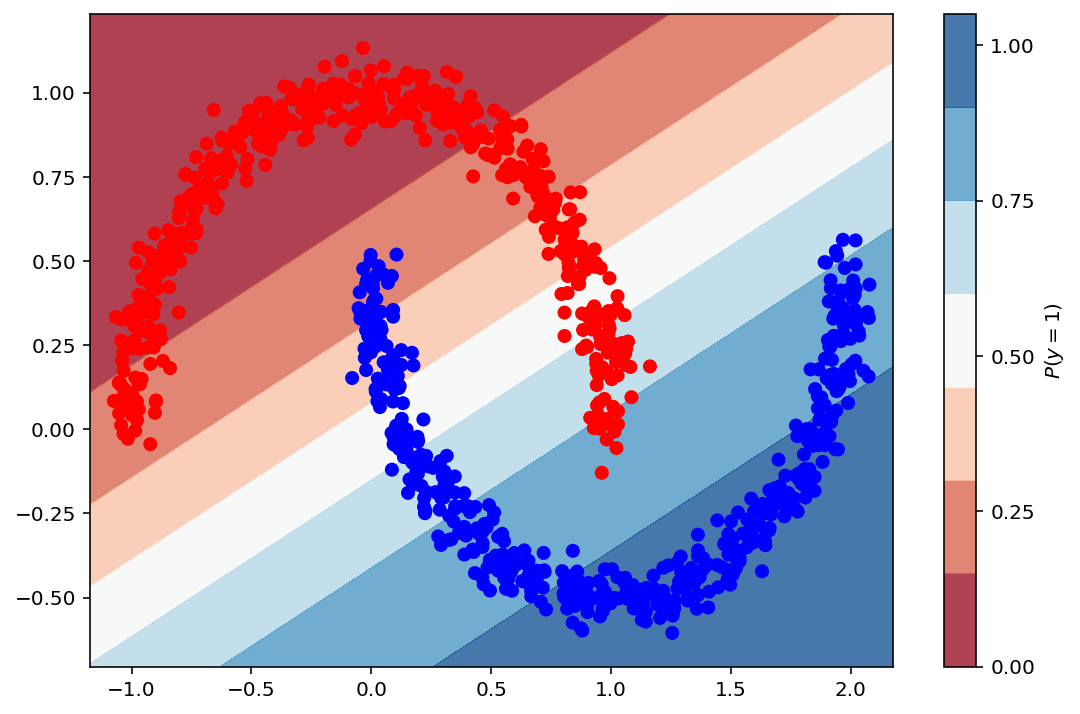

In [ ]:
plot_decision_boundary(lambda x: model_2.predict(x), X, y)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       500
           1       0.86      0.86      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



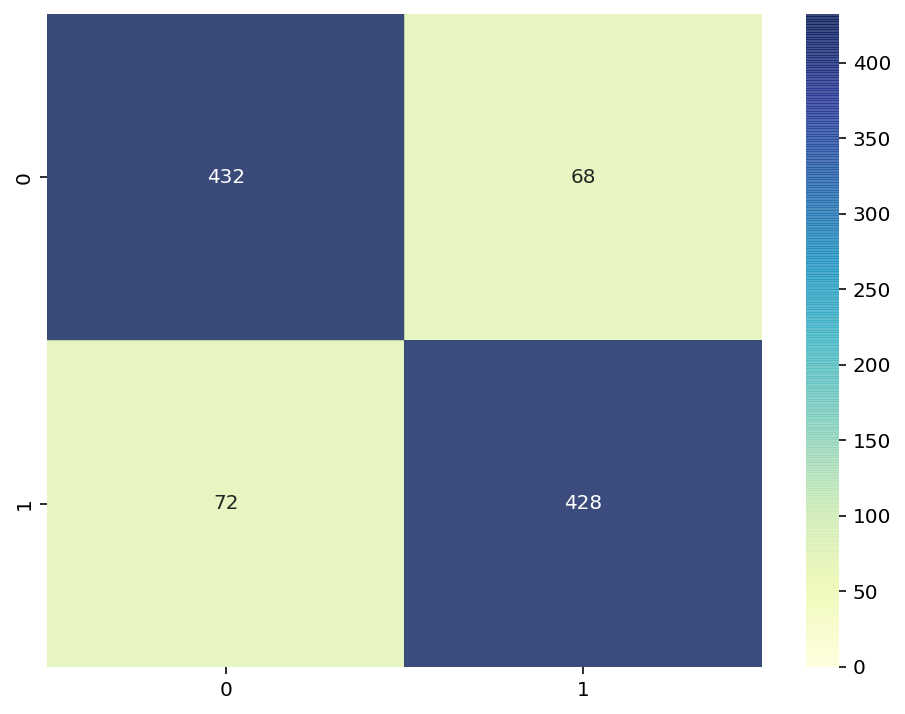

In [ ]:
y_pred_2 = (model_2.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_2))

plot_confusion_matrix(model_2, X, y)

#Model 3

Complex Data - Circles

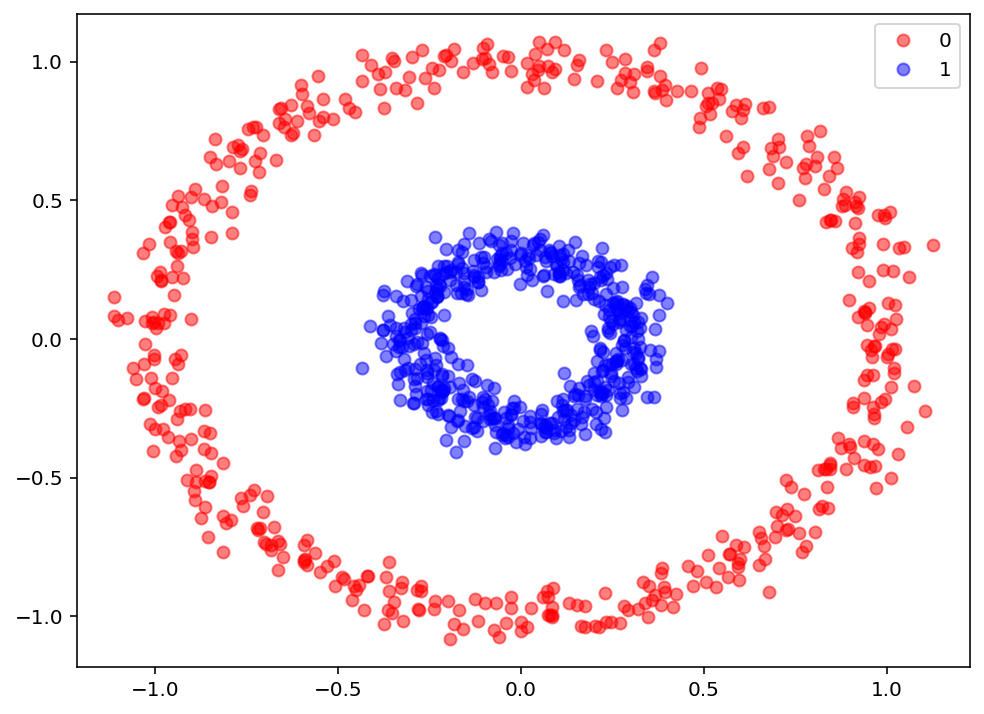

In [ ]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

<Figure size 576x432 with 0 Axes>

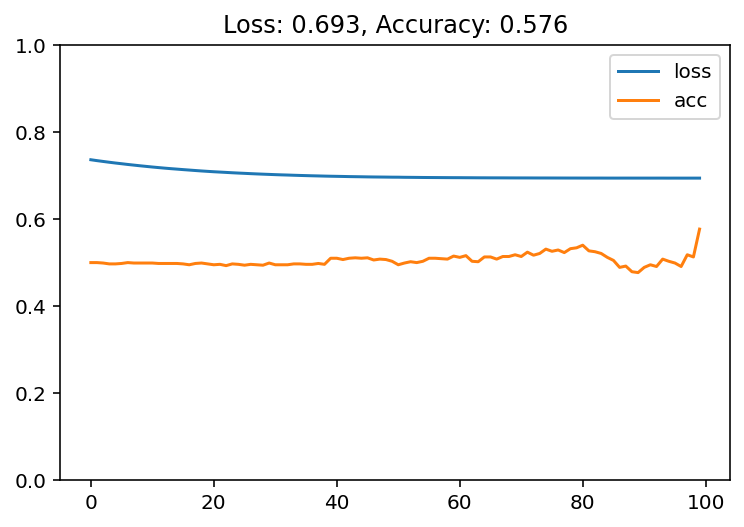

In [ ]:
model_3 = Sequential()
model_3.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model_3.compile('adam', 'binary_crossentropy', metrics=['acc'])

history_3 = model_3.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history_3)

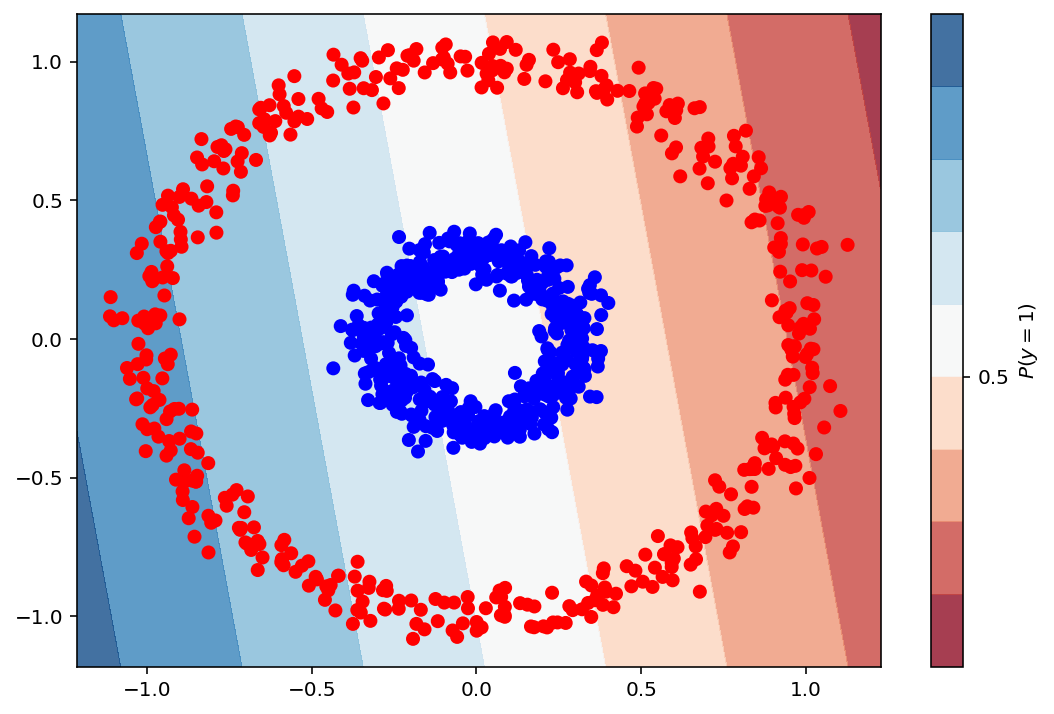

In [ ]:
plot_decision_boundary(lambda x: model_3.predict(x), X, y)

              precision    recall  f1-score   support

           0       0.64      0.43      0.52       500
           1       0.57      0.75      0.65       500

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.58      1000
weighted avg       0.60      0.59      0.58      1000



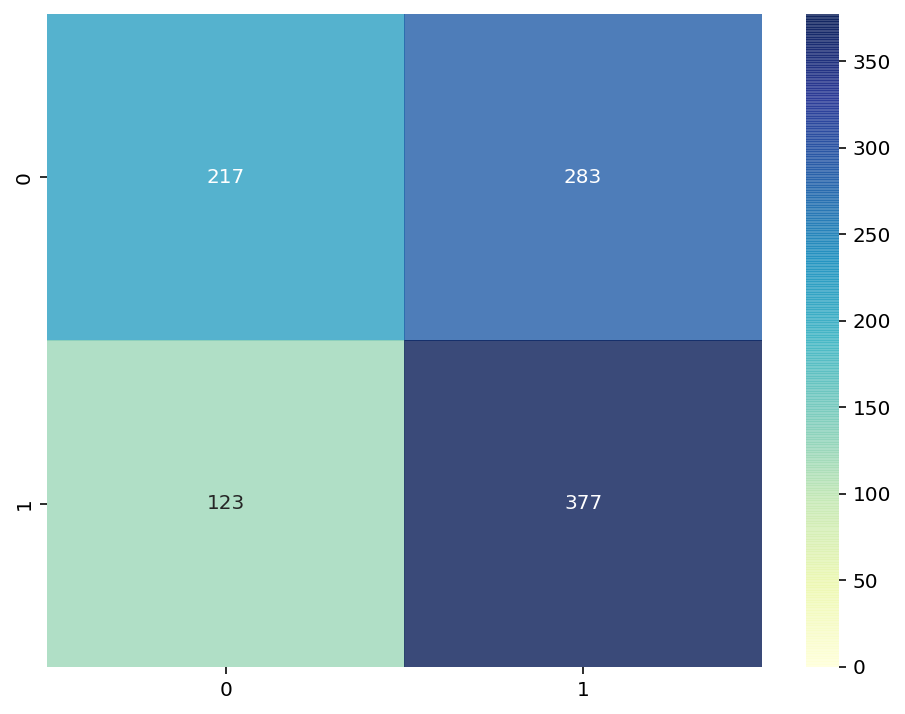

In [ ]:
y_pred_3 = (model_3.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_3))

plot_confusion_matrix(model_3, X, y)

# **Artificial Neural Networks (ANN)**

#Training a Deep Neural Network

Now we will train a deep Artificial Neural Network (ANN) to better classify the datasets which the logistic regression model struggled, Moons and Circles datasets. We will also classify an even harder dataset of Sine Wave to demonstrate that ANNs can form really complex decision boundaries.

<Figure size 576x432 with 0 Axes>

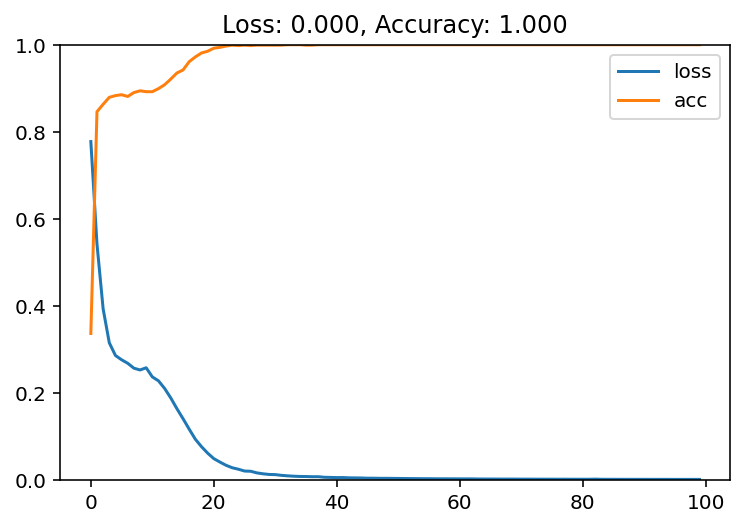

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model_4 = Sequential()
model_4.add(Dense(4, input_shape=(2,), activation='tanh'))
model_4.add(Dense(2, activation='tanh'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['acc'])

history_4 = model_4.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history_4)

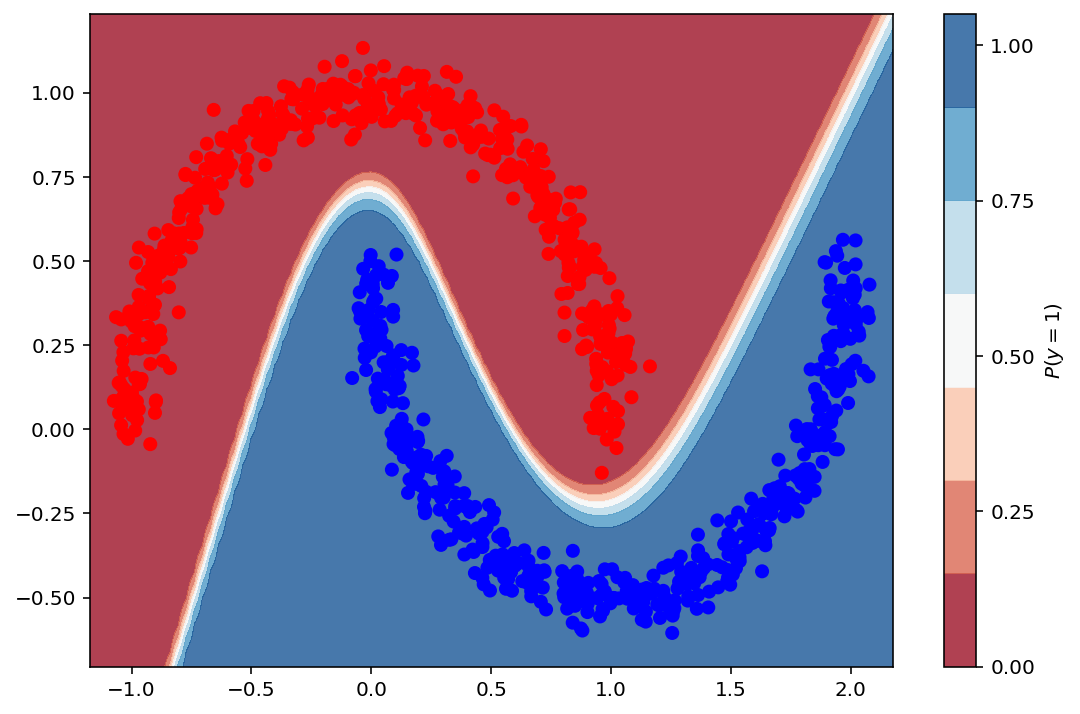

In [ ]:
plot_decision_boundary(lambda x: model_4.predict(x), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



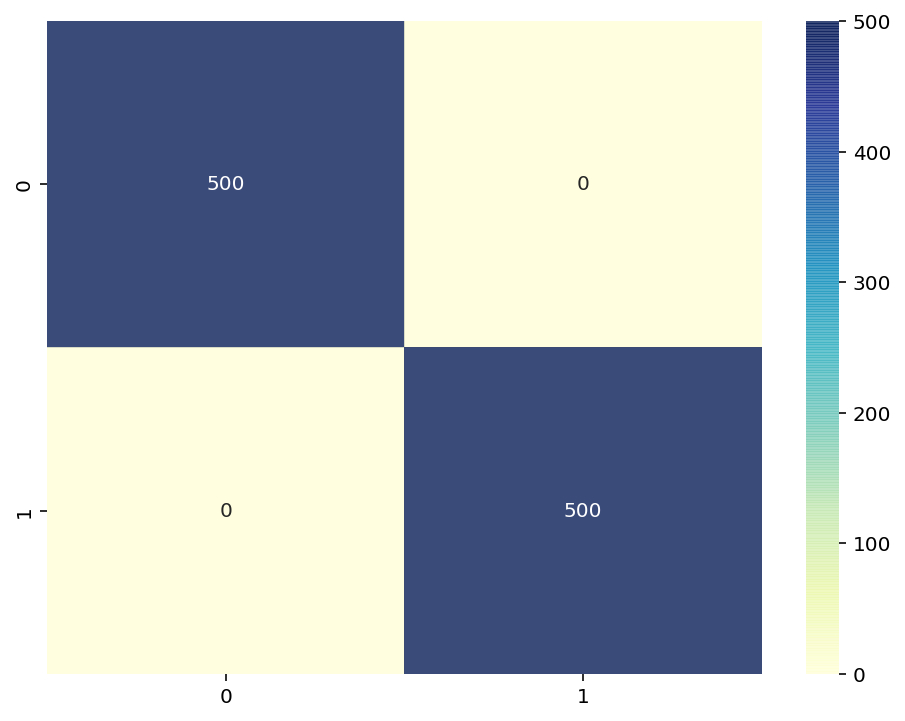

In [ ]:
y_pred_4 = (model_4.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_4))

plot_confusion_matrix(model_4, X, y)

#Model 5

Complex Data - Circles

<Figure size 576x432 with 0 Axes>

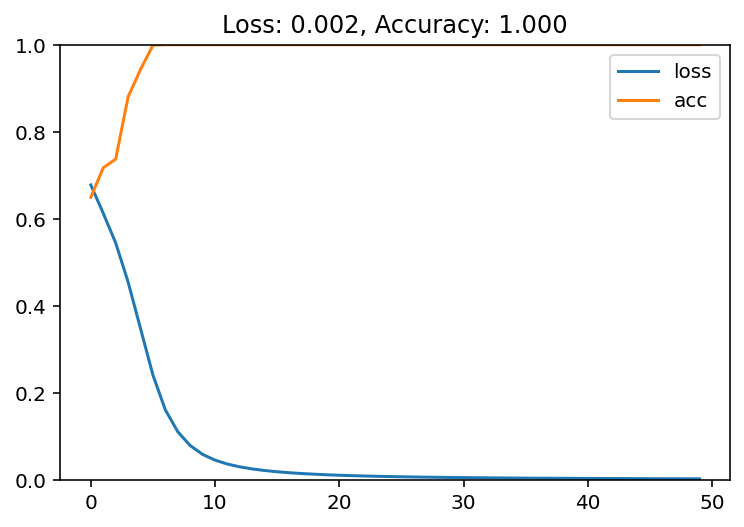

In [ ]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model_5 = Sequential()
model_5.add(Dense(4, input_shape=(2,), activation='tanh'))
model_5.add(Dense(2, activation='tanh'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['acc'])

history_5 = model_5.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history_5)

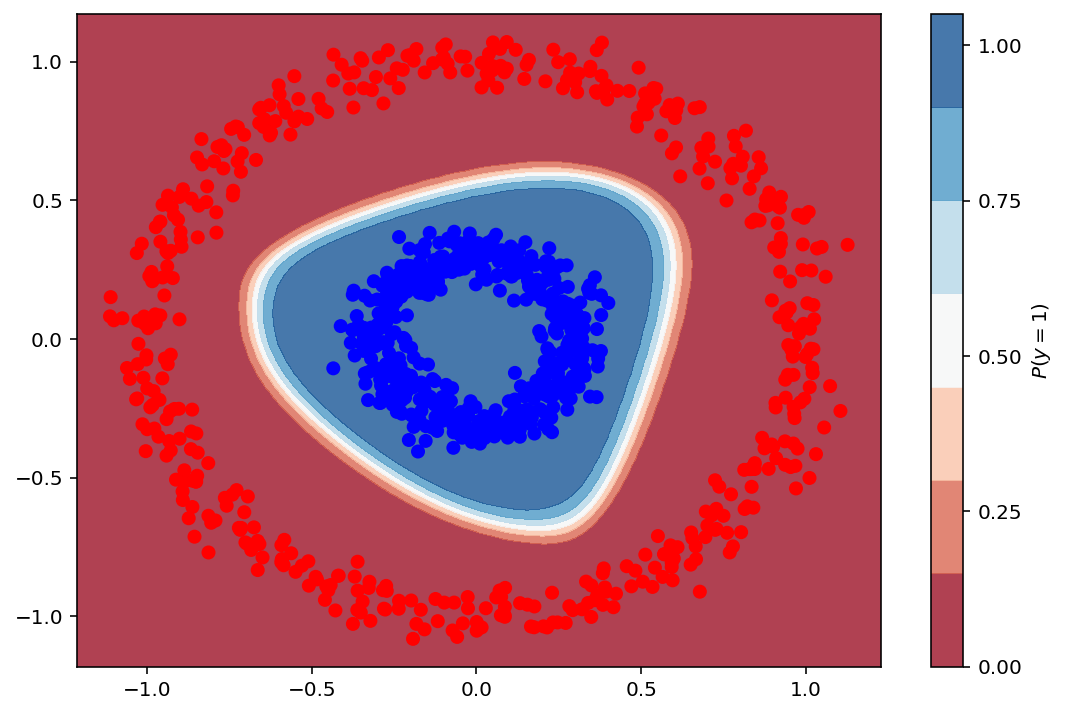

In [ ]:
plot_decision_boundary(lambda x: model_5.predict(x), X, y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



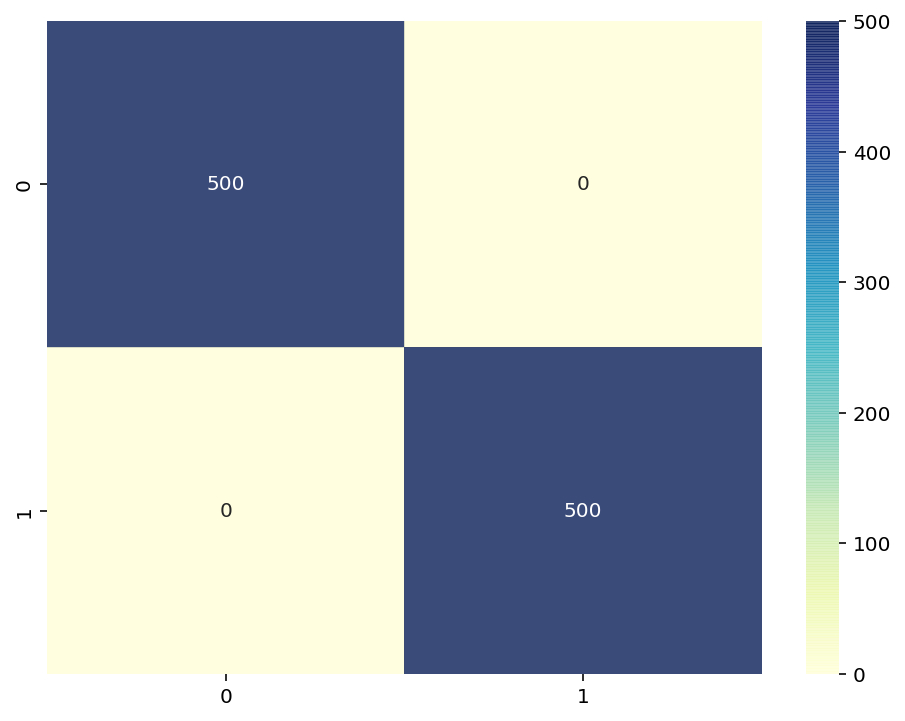

In [ ]:
y_pred_5 = (model_5.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_5))

plot_confusion_matrix(model_5, X, y)

Complex Data - Sine Wave

#Model 6

<Figure size 576x432 with 0 Axes>

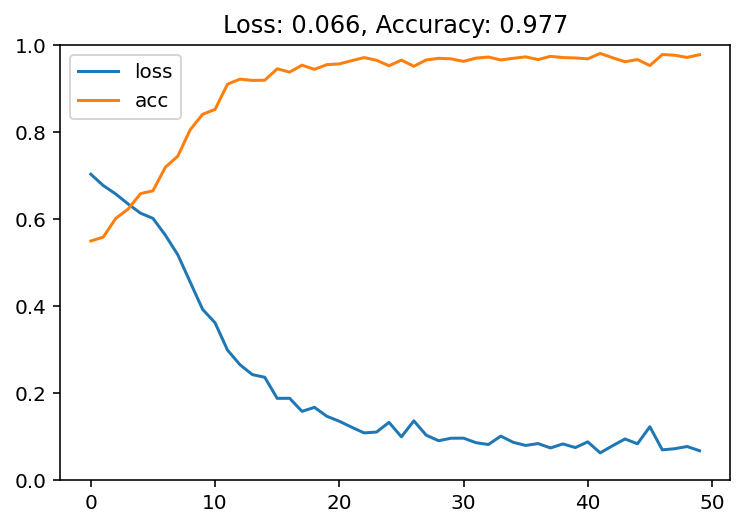

In [217]:
X, y = make_sine_wave()

model_6 = Sequential()
model_6.add(Dense(64, input_shape=(2,), activation='tanh'))
model_6.add(Dense(64, activation='tanh'))
model_6.add(Dense(64, activation='tanh'))
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile('adam', 'binary_crossentropy', metrics=['acc'])

history_6 = model_6.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history_6)

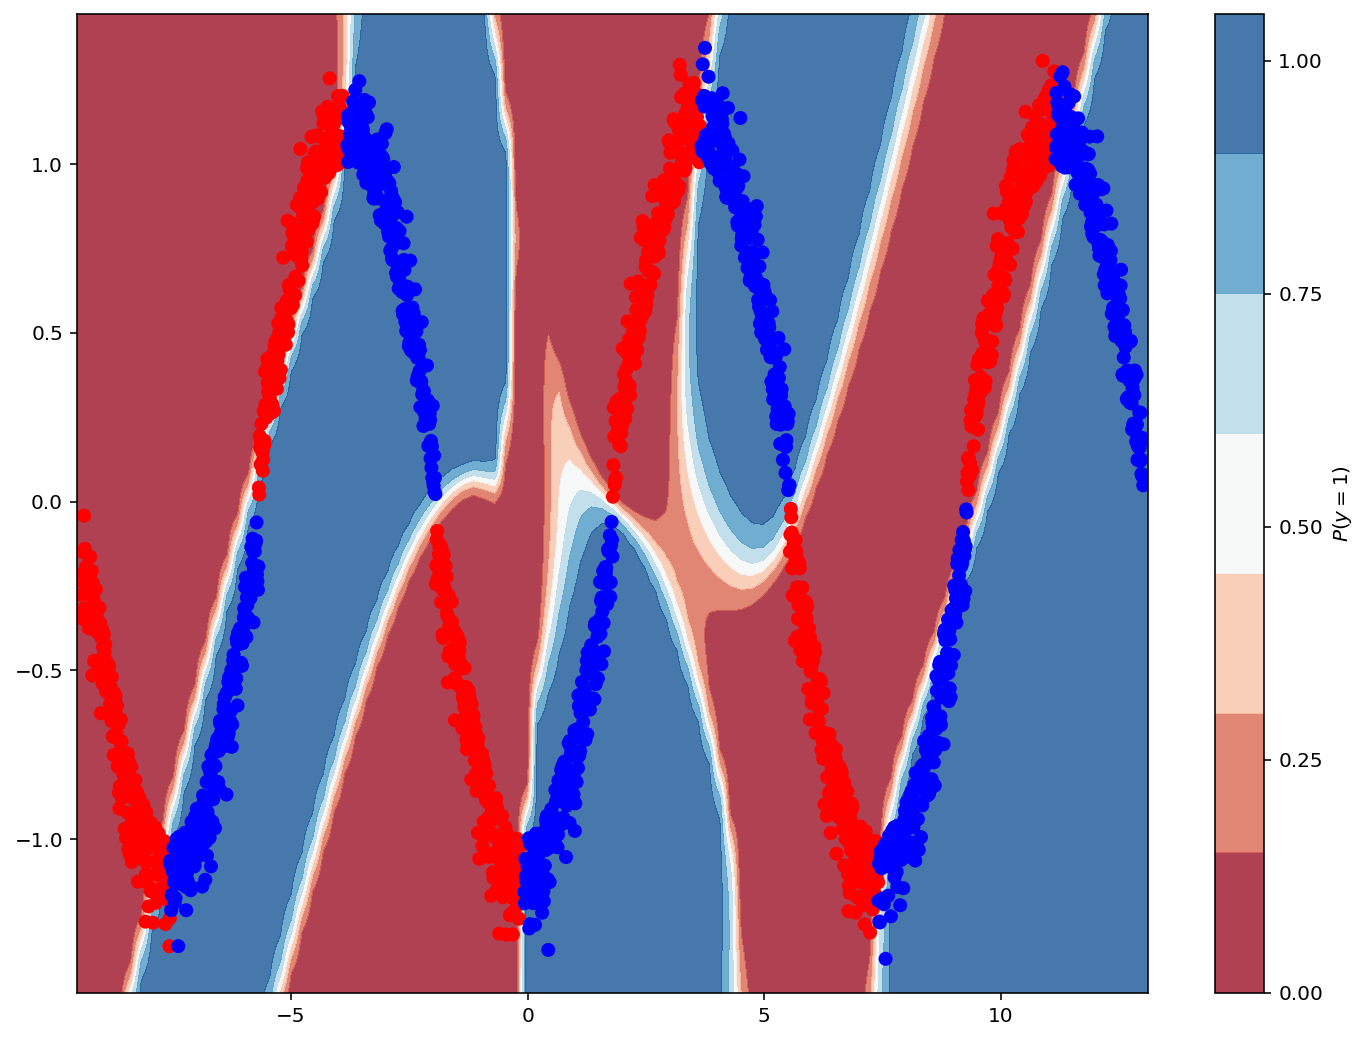

In [218]:
plot_decision_boundary(lambda x: model_6.predict(x), X, y, figsize=(12, 9))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1200
           1       0.96      0.94      0.95      1200

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



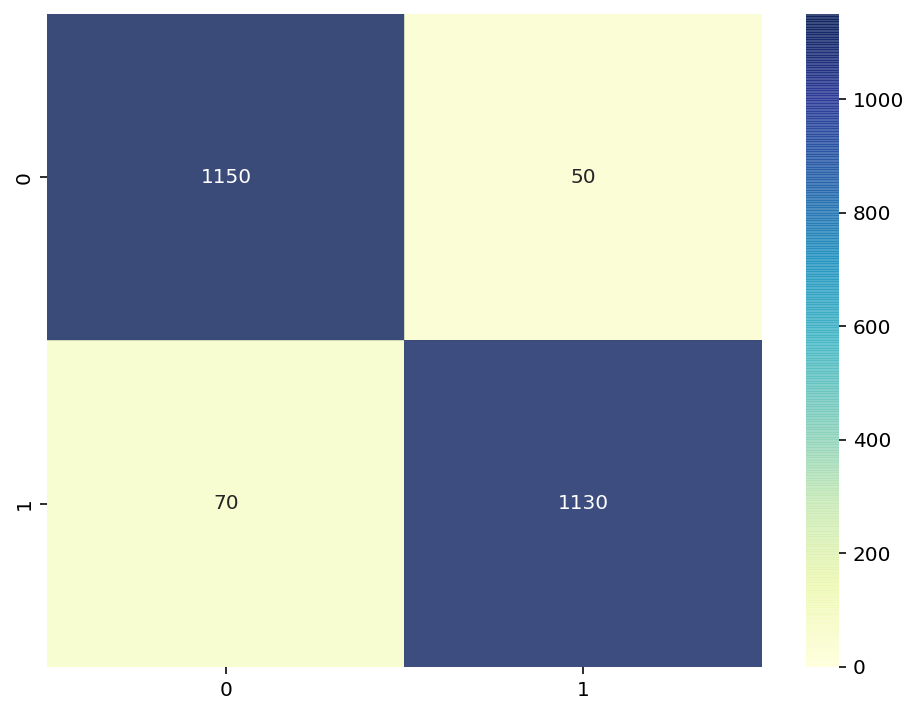

In [219]:
y_pred_6 = (model_6.predict(X, verbose = 0) > 0.5).astype("int32")
print(classification_report(y, y_pred_6))

plot_confusion_matrix(model_6, X, y)

# **Multiclass Classification**

#Model 7

Multiclass Classification

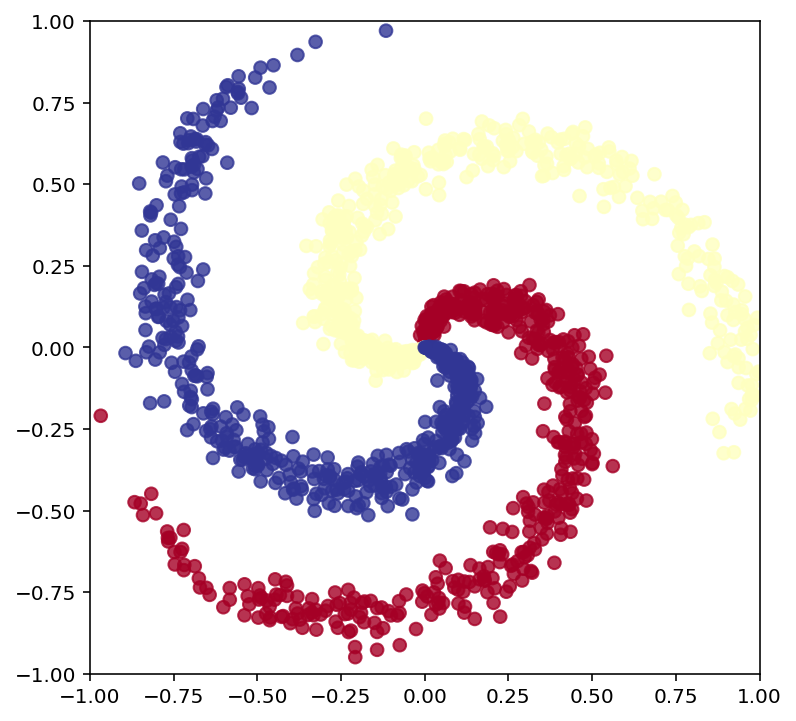

<Figure size 576x432 with 0 Axes>

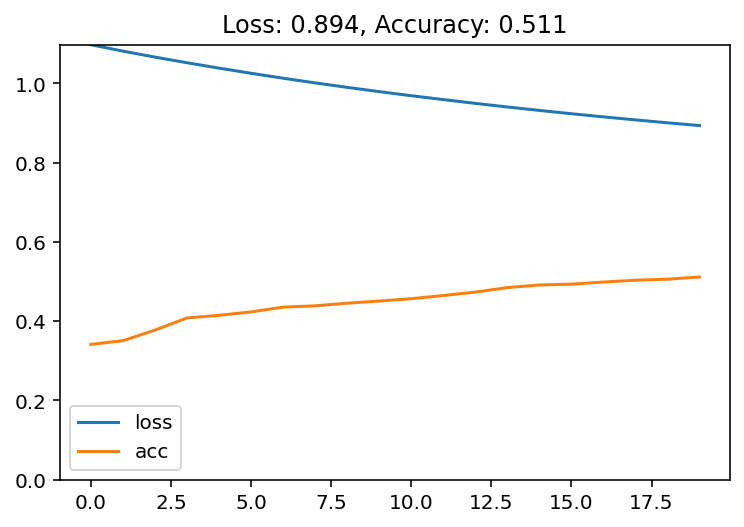

In [224]:
X, y = make_multiclass(K=3)

model_7 = Sequential()
model_7.add(Dense(3, input_shape=(2,), activation='softmax'))
model_7.compile('adam', 'categorical_crossentropy', metrics=['acc'])

y_cat = to_categorical(y)

history_7 = model_7.fit(X, y_cat, verbose=0, epochs=20)
plot_loss_accuracy(history_7)

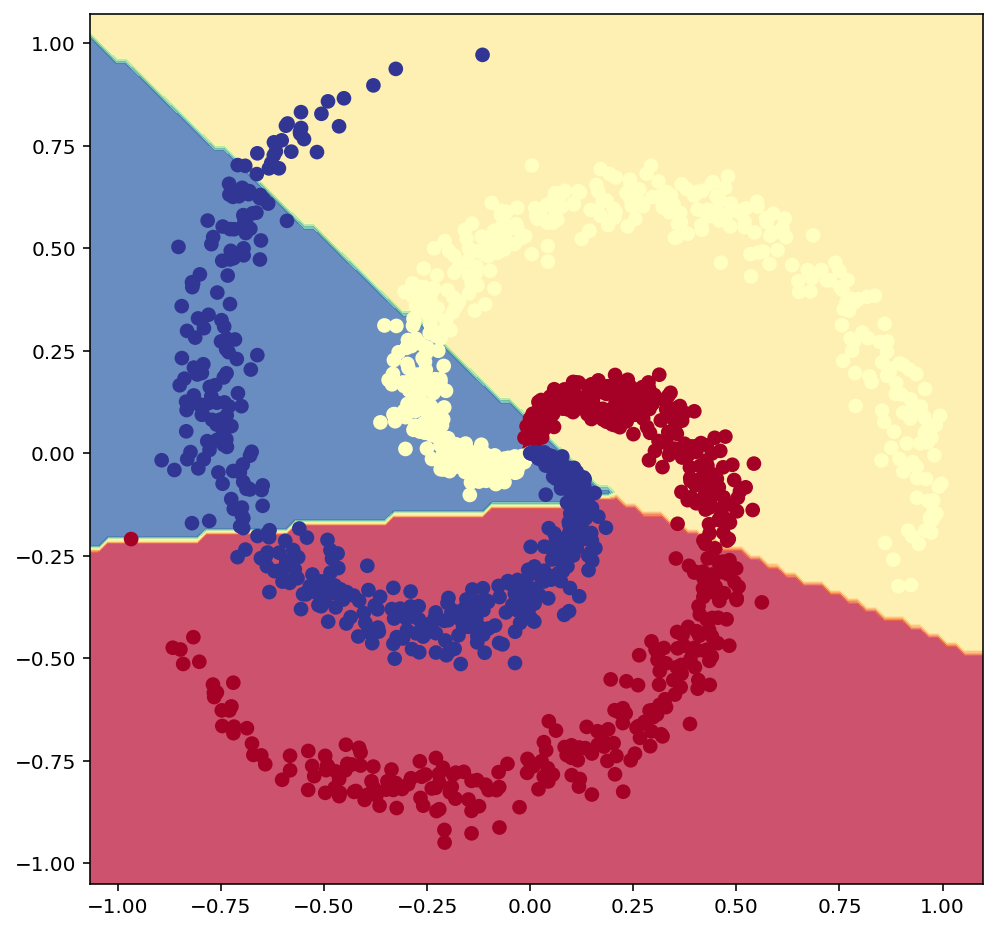

In [225]:
plot_multiclass_decision_boundary(model_7, X, y)

              precision    recall  f1-score   support

         0.0       0.49      0.49      0.49       500
         1.0       0.55      0.61      0.58       500
         2.0       0.49      0.43      0.46       500

    accuracy                           0.51      1500
   macro avg       0.51      0.51      0.51      1500
weighted avg       0.51      0.51      0.51      1500



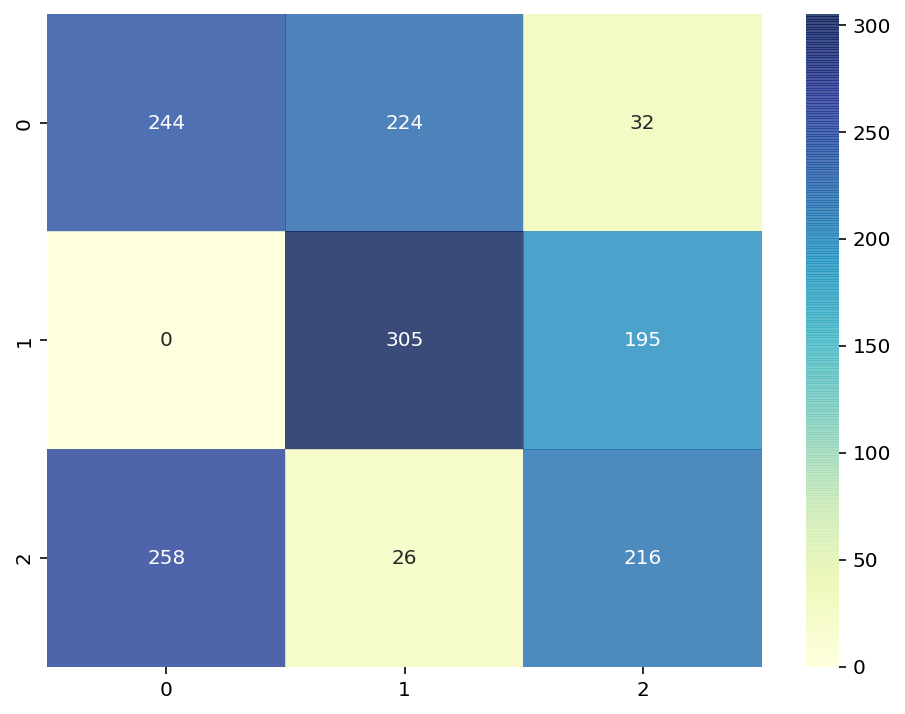

In [229]:
predict_y=model_7.predict(X) 
y_pred_7=np.argmax(predict_y,axis=1)
print(classification_report(y, y_pred_7))

#plot_confusion_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred_7)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

# Model 8

<Figure size 576x432 with 0 Axes>

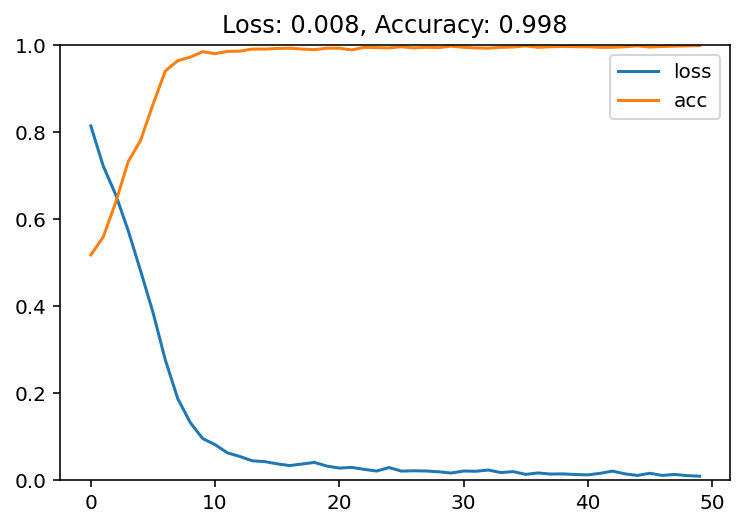

In [230]:
model_8 = Sequential()
model_8.add(Dense(128, input_shape=(2,), activation='tanh'))
model_8.add(Dense(64, activation='tanh'))
model_8.add(Dense(32, activation='tanh'))
model_8.add(Dense(16, activation='tanh'))
model_8.add(Dense(3, activation='softmax'))

model_8.compile('adam', 'categorical_crossentropy', metrics=['acc'])

y_cat = to_categorical(y)
history_8 = model_8.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history_8)

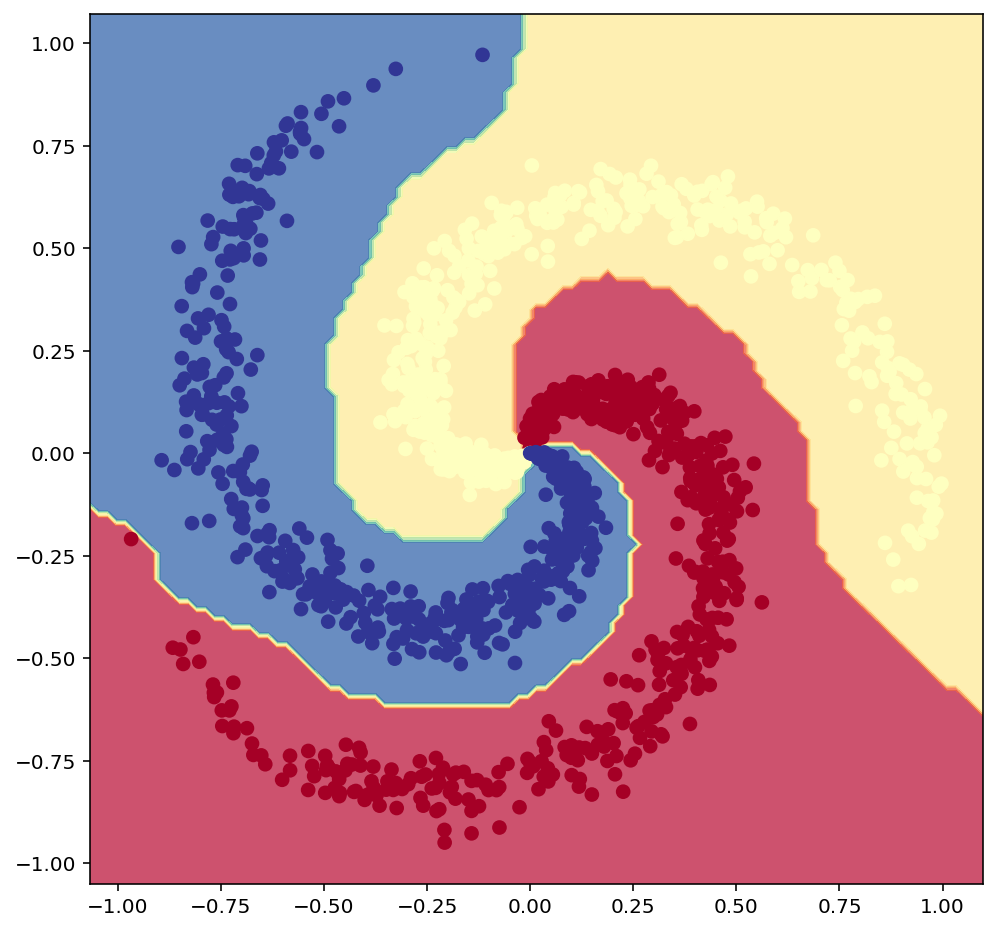

In [231]:
plot_multiclass_decision_boundary(model_8, X, y)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       500
         1.0       1.00      1.00      1.00       500
         2.0       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



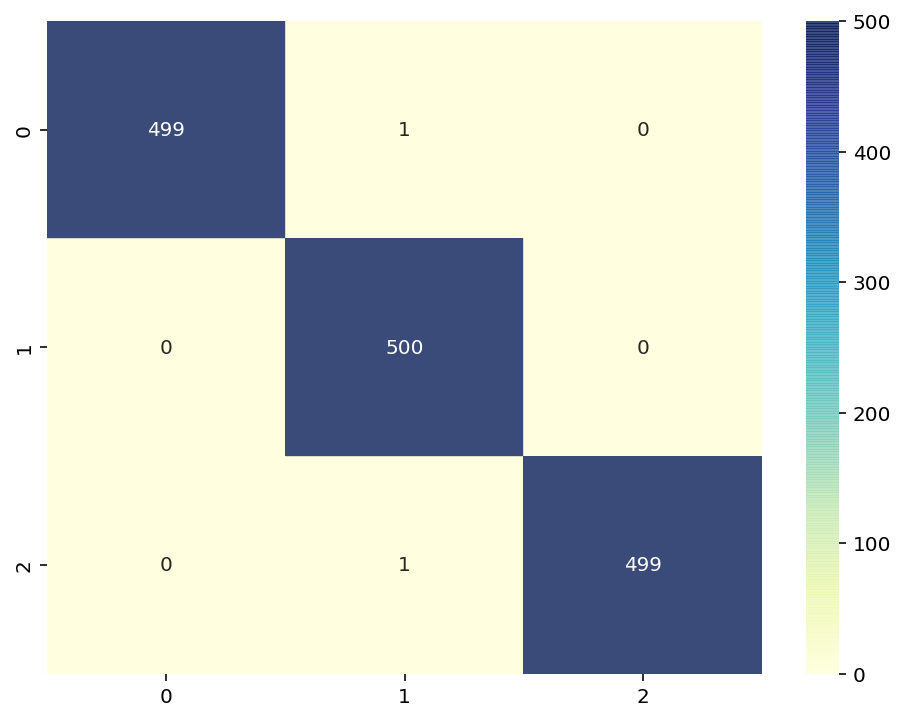

In [232]:
predict_y=model_8.predict(X) 
y_pred_8=np.argmax(predict_y,axis=1)
print(classification_report(y, y_pred_8))

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred_8)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)